# From Affinities to Segmentation

## Exercise 1: Load the inference results
1. make sure you predicted affinities with `02_inference.ipynb`
2. You have two different datasetsizes written out, examples are nicer with datasetsize=big, but if the functions are too slow for you, consider to switch to datasetsize=small


### Help & Troubleshooting
- If your notebook is hanging, sometimes it helps to restart the kernel: For this go to `Kernel` and then `Restart & Clear Output`
- We experience some issues when running multiple `neuroglancer` instances at the same time. Make sure you close the tab of one `neuroglancer` instance before you run the next `neuroglancer` cell. 

In [19]:
import daisy
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
import funlib.segment
import malis
import matplotlib.gridspec as gridspec
import waterz
import logging
from importlib import reload
import utils
import funlib.show.neuroglancer as funlibng
import neuroglancer
logging.basicConfig(level=logging.INFO)

In [20]:
# Load the data (make sure you ran inference.ipynb before).
# By default, you wrote out the big ROI at iteration 500000. However, if you changed iteration 
# or datasetsize, model or out_file name
datasetsize = 'big' # change accordingly
iteration = 500000 # Change to check out other training iterations
aff_file = 'affinities_{}_{:05}.zarr'.format(datasetsize, iteration)


# --------- Do Not Change --------
gt_file = '../../jan/segmentation/data/sample_0.n5'
affs_ds = daisy.open_ds(aff_file, 'volumes/affs')
raw_ds = daisy.open_ds(aff_file, 'volumes/raw')
gtds = daisy.open_ds(gt_file, 'volumes/labels/neuron_ids')

roi = affs_ds.roi.intersect(gtds.roi) # The Region of Interest that we will look at in this notebook

gt = gtds.to_ndarray(roi)
raw = raw_ds.to_ndarray(roi)
affs = affs_ds.to_ndarray(roi)

z_section = 9 # For 2d Visualization, always pick the same z_section

Text(0.5, 1.0, 'Raw')

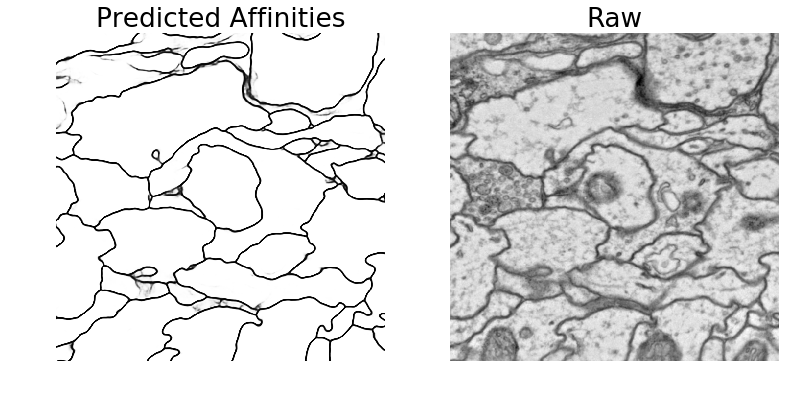

In [21]:
# Affinities are in z,y,x direction, here average over x and y vor visualization.
mean_affs = 0.5*(affs[1] + affs[2]) 

plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(1, 3)

ax = plt.subplot(gs[0,0])
plt.imshow(np.squeeze(mean_affs[z_section, :, :]), cmap='gray')
ax.axis('off')  # clear x- and y-axes
plt.title('Predicted Affinities')

ax = plt.subplot(gs[0,1])
ax.imshow(raw[z_section, :], cmap='gray')
ax.axis('off')  # clear x- and y-axes
plt.title('Raw')

## Obtain a segmentation by thresholding
Given a perfect boundary prediction, obtaining a segmentation would be trivial. It would be enough to create a binary mask by thresholding and then finding connected component. As we will see, minor errors in our boundary predictions can lead to catastropical errors in our segmentation
### 2D example

In [22]:
def connected_component_sectionwise(affs, threshold):
    mean_affs = 0.5*(affs[1] + affs[2])
    depth = mean_affs.shape[0]
    cc = np.zeros(mean_affs.shape, dtype=np.uint64)
    boundary = np.zeros(mean_affs.shape, dtype=np.uint8)
    for z in range(depth):
        boundary_mask = mean_affs[z] > 0.5

        boundarysingle = mean_affs[z, :] > threshold
        ccsingle, num_labels = ndimage.label(boundarysingle)
        cc[z] = ccsingle
        boundary[z] = boundarysingle
    return cc, boundary

threshold = 0.3
cc, boundary = connected_component_sectionwise(affs, threshold)

Text(0.5, 1.0, 'ConnectedComponents')

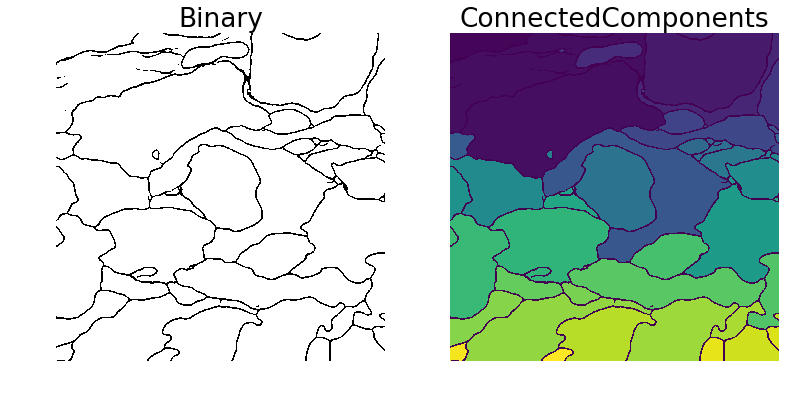

In [23]:
plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(1, 3)

ax = plt.subplot(gs[0,0])
ax.imshow(boundary[z_section, :], cmap='gray')
ax.axis('off')  # clear x- and y-axes
plt.title('Binary')

ax = plt.subplot(gs[0,1])
ax.imshow(cc[z_section, :], cmap='viridis')
ax.axis('off')  # clear x- and y-axes
plt.title('ConnectedComponents')

As for the snapshots, to get a good impression, it is better to explore the data in 3D with neuroglancer.

In [24]:
neuroglancer.set_server_bind_address('0.0.0.0')
viewer = neuroglancer.Viewer()
with viewer.txn() as s:
    funlibng.add_layer(s, raw_ds, 'raw')
    funlibng.add_layer(s, affs_ds, 'affs', shader='rgb')
    funlibng.add_layer(s, daisy.Array(cc, roi, affs_ds.voxel_size), 'connected components')
    funlibng.add_layer(s, daisy.Array(boundary, roi, affs_ds.voxel_size), 'Binary')
print(viewer.__str__())

http://c04u01.int.janelia.org:37574/v/ae4d3de2ad305bb6647ae2364d26e59ed9627f94/


## Exercise 1 : Connected Component in 2D
1. Try out connected components for different thresholds and explore the effect in neuroglancer.
2. For this, use the function `connected_component_sectionwise` of this notebook

In [25]:
# Here you should type your solution
# ......

### 3D example
The 2D example already shows, that some neurons accidently gets merged, when there is a small hole in the membrane. This gets worse, if you do the same procedure in 3D.


Text(0.5, 1.0, 'Connected Component from Affinity Graph')

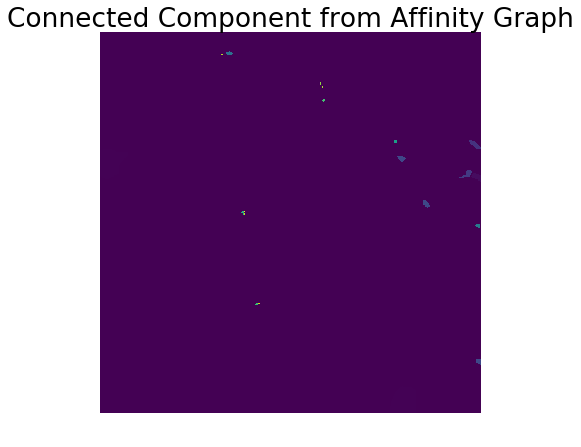

In [26]:
nhood = [[-1, 0, 0], [0, -1, 0], [0, 0, -1]]
cc_3d, __ = malis.connected_components_affgraph(np.array(affs > threshold, dtype=np.int32),np.array(nhood))
fig, ax = plt.subplots(figsize=(7,7))

im = ax.imshow(cc_3d[z_section, :], cmap='viridis')
ax.axis('off')  # clear x- and y-axes
plt.title('Connected Component from Affinity Graph')

In [27]:
neuroglancer.set_server_bind_address('0.0.0.0')
viewer = neuroglancer.Viewer()
with viewer.txn() as s:
    funlibng.add_layer(s, raw_ds, 'raw')
    funlibng.add_layer(s, affs_ds, 'affs', shader='rgb')
    funlibng.add_layer(s, daisy.Array(cc_3d, roi, affs_ds.voxel_size), 'connected components')
print(viewer.__str__())

http://c04u01.int.janelia.org:37574/v/a16e15eb8e0926c8379e5bf59c5c66b69e90b9e5/


# Use Watershed and Fragment Agglomeration for a more robust segmentation
## Creation of Fragments
We use the watershed algorithm to create an oversegmentation. The Watershed is more robust towards small errors in the hole.

INFO:utils:Number of fragments in volume: 30651


Text(0.5, 1.0, 'Raw')

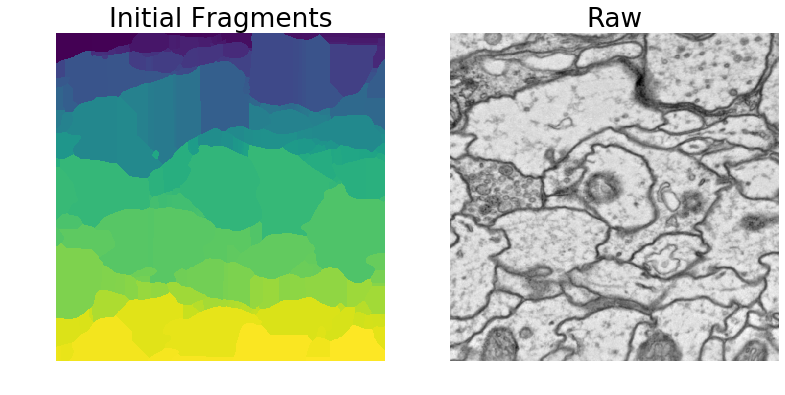

In [28]:
fragments = utils.apply_watershed(affs, fragments_in_xy=True)

plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(1, 3)

ax = plt.subplot(gs[0,0])
plt.imshow(fragments[z_section, :], cmap='viridis')
ax.axis('off')  # clear x- and y-axes
plt.title('Initial Fragments')

ax = plt.subplot(gs[0,1])
ax.imshow(raw[z_section, :], cmap='gray')
ax.axis('off')  # clear x- and y-axes
plt.title('Raw')

## Agglomeration
The watershed is good to prevent too much merging. However, we can clearly see, that now the neurons are broken into too many pieces. In this part, we will see, how we can agglomerate those little pieces / fragments into larger ones.


In [29]:
threshold = 0.9
segments = utils.agglomerate_fragments(affs, fragments, threshold)

Re-using already compiled waterz version
Preparing segmentation volume...


INFO:utils:Number of segments in volume: 3546


Text(0.5, 1.0, 'Raw')

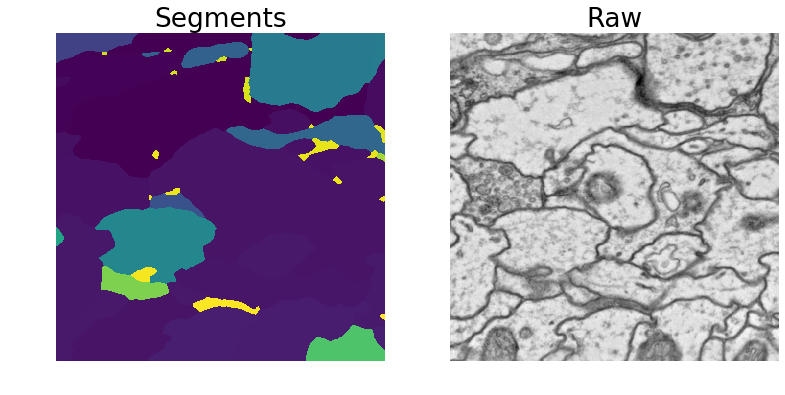

In [30]:
plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(1, 3)

ax = plt.subplot(gs[0,0])
plt.imshow(np.array(segments[z_section, :], dtype=np.float32), cmap='viridis')
ax.axis('off')  # clear x- and y-axes
plt.title('Segments')

ax = plt.subplot(gs[0,1])
ax.imshow(raw[z_section, :], cmap='gray')
ax.axis('off')  # clear x- and y-axes
plt.title('Raw')


### Exercise 2: How does the segmentation change when we change the agglomeration threshold ?
1. Try to find a threshold, that produces meaningful results (this means, ideally, no two neurons should be merged together, and not a single neuron should be split into two segments

2. We also add our ground truth data here, such that you see, what we are aiming for 

In [31]:
# Here you should type your solution
# 1) apply agglomeration functions for different thresholds (utils.agglomerate_fragments)
# 2) see the result in neuroglancer

In [32]:
neuroglancer.set_server_bind_address('0.0.0.0')
viewer = neuroglancer.Viewer()
with viewer.txn() as s:
    funlibng.add_layer(s, raw_ds, 'raw')
    funlibng.add_layer(s, affs_ds, 'affs', shader='rgb')
    funlibng.add_layer(s, daisy.Array(fragments, roi, affs_ds.voxel_size), 'Fragments')
    funlibng.add_layer(s, daisy.Array(segments, roi, affs_ds.voxel_size), 'Segmentation')
    funlibng.add_layer(s, daisy.Array(gt, roi, affs_ds.voxel_size), 'Ground Truth')
    # Add here more segmentation with different thresholds
    
    # funlibng.add_layer(s, daisy.Array(segment_thr05, roi, affs_ds.voxel_size), 'Segmentation')

    print(viewer.__str__())

http://c04u01.int.janelia.org:37574/v/ba18efc38bcbdd06ae63c8c265fa24201d9e2dff/


### Evaluation (Extra Exercises)
So far, we only assessed qualitatively our results. Now, we will have a look how we can quantitavely check the performance our of our models. For this, we use our ground truth data to compare it to our predicted segmentation,

In [33]:
gt, __ = funlib.segment.arrays.relabel(gt, inplace=True)

(-0.5, 671.5, 671.5, -0.5)

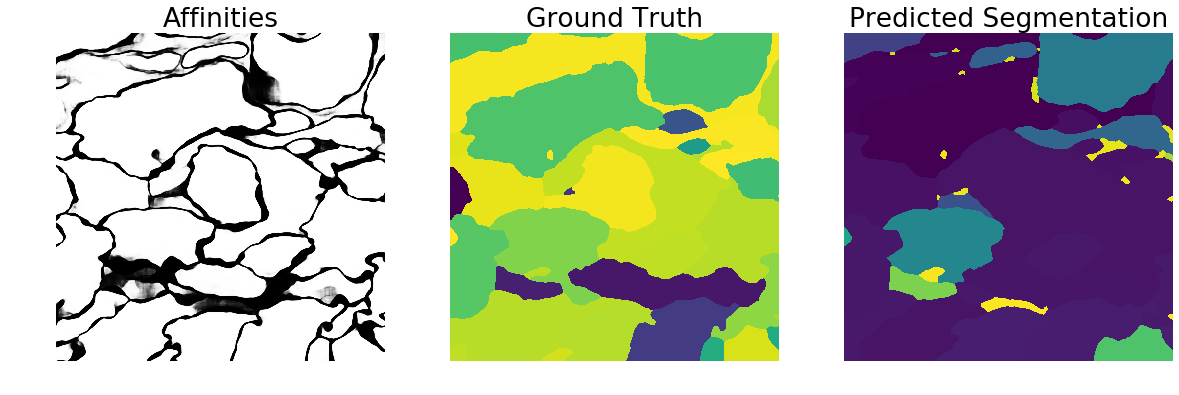

In [34]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(1, 3)

ax = plt.subplot(gs[0,0])
plt.imshow(np.squeeze(affs[0, z_section, :]), cmap='gray')
ax.set_title('Affinities')
ax.axis('off') 
ax = plt.subplot(gs[0,1])
ax.imshow(np.squeeze(gt[z_section, :]), cmap='viridis')
ax.set_title('Ground Truth')
ax.axis('off') 
ax = plt.subplot(gs[0,2])
ax.imshow(segments[z_section, :], cmap='viridis')
ax.set_title('Predicted Segmentation')
ax.axis('off') 

We use 2 measurements for evaluation: `Rand Index` and `VOI`

In [35]:
metric = waterz.evaluate(gt, segments)
print(metric)

{'voi_split': 0.11305582175649853, 'voi_merge': 0.8910880396083138, 'rand_split': 0.9760988436102359, 'rand_merge': 0.4860892448315053}


### Exercise 3: How does VOI_split and VOI_merge change with changing agglomeration thresholds ?
In this exercise you should

  1. create multiple segmentations for different thresholds
  2. Evalute each segmentation against the ground truth segmentation (with the function above: `waterz.evaluate`)
  3. Make a a) plot with the threshold plotted against VOI_split and b) a plot with the threshold plotted against VOI_merge
  4. Check out the [CREMI benchmark](www.cremi.org) and see what state of the art results are and put your numbers into context




In [36]:
# Here you should type your solution
# ......

### Exercise 5 (extra, extra, extra :)) : Does the same for different checkpoints
eg. how do those numbers evolve during training, eg. at 30k, 60k ?
In this exercise you should

  1. create multiple segmentations for different iterations
  2. Evalute each segmentation against the ground truth segmentation
  3. Make a a) plot with the iteration plotted against VOI_split and b) a plot with the iteration plotted against VOI_merge
  4. Check out the [CREMI benchmark](www.cremi.org) and see what state of the art results are